In [1]:
import sys
sys.path.append("../")
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
import seaborn as sns
import ICP
import importlib
from PDE2D import *
import Mahalanobis
from SyntheticExamples import FlatTorusIdeal
from Kuramoto import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms

# Sampling Two Types of Line Segments / Computing Mahalanobis Diffusion Maps



In [2]:
## First setup the solution grid of the Kuramoto Sivashinsky equation
np.random.seed(1)
fac = 0.5
ks1 = KSSimulation(co_rotating=False, scale=(fac*10, fac/1.42), reldir='../')
ks1.crop(0, 220, 0, ks1.I.shape[1])
ks2 = KSSimulation(co_rotating=False, scale=(fac*10, fac/1.42), reldir='../')
ks2.crop(0, 220, 0, ks2.I.shape[1])
theta1 = np.pi/3
theta2 = 2*np.pi/3

In [3]:
## Sample observations of one type and of another type
pd = (80, 1)
nsamples = 4000
ks1.makeObservations(pd, nsamples, rotate=False, uniform=False)
ks1.thetas = theta1*np.ones_like(ks1.thetas)
ks1.completeObservations()
ks2.makeObservations(pd, nsamples, rotate=False, uniform=False)
ks2.thetas = theta2*np.ones_like(ks2.thetas)
#ks2.Xs[-4::] = ks1.Xs[-4::] # Make the last 4 observations at the same location
#ks2.Ts[-4::] = ks1.Ts[-4::]
ks2.completeObservations()
ks1.concatenateOther(ks2)
ks = ks1
idxresort = ks.resort_byrandom()

Making 4000 observations of dimension (80, 1) on a grid of (220, 140)...
Elapsed time patch sampling: 0.154
Elapsed time patch sampling: 0.143
Making 4000 observations of dimension (80, 1) on a grid of (220, 140)...
Elapsed time patch sampling: 0.246
Elapsed time patch sampling: 0.13


In [4]:
## Compute the Mahalanobis distance and mask indices
delta = 5
n_points = 100
rank = 2
maxeigs = 100
dMaxSqr = 1000
res = Mahalanobis.getMahalanobisDists(ks.patches, ks.get_mahalanobis_ellipsoid, delta, \
                      n_points=n_points, rank=rank, maxeigs=maxeigs)
gamma, maskidx = res["gamma"], res["maskidx"]

Computing Jacobians, rank = 2, maxiegs = 80...
0 of 8000
500 of 8000
1000 of 8000
1500 of 8000
2000 of 8000
2500 of 8000
3000 of 8000
3500 of 8000
4000 of 8000
4500 of 8000
5000 of 8000
5500 of 8000
6000 of 8000
6500 of 8000
7000 of 8000
7500 of 8000
Elapsed Time: 33.2
Computing Mahalanobis Distances...
Elapsed Time: 284


In [5]:
## Compute diffusion maps and TDA at all thresholds of the mask
eps = dMaxSqr*np.max(gamma)*1e-3 # Autotune diffusion eps in terms of point cloud diameter
# Try different thresholds of the Mahalanobis mask
res = getMahalanobisAllThresh(gamma, maskidx, eps=eps, neigs=20, flip=False, verbose=True)
Ys, alldgms = res["Ys"], res["alldgms"]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 Elapsed Time: 980


In [6]:
# Compute the top most persistent h0, the top 4 most persistent h1s, 
# and the top two persistent h2s at each threshold, and use these
# to choose the optimal threshold
N = len(alldgms)
h0 = np.zeros(N)
h1s = np.zeros((N, 4))
h2s = np.zeros((N, 2))
for i, dgms in enumerate(alldgms):
    h0i, h1i, h2i = dgms[0:3]
    h0i = h0i[np.isfinite(h0i[:, 1]), :]
    if h0i.size > 0:
        h0[i] = np.max(h0i[:, 1])
    if h1i.size > 0:
        h1si = h1i[:, 1] - h1i[:, 0]
        h1si = h1si[np.argsort(-h1si)]
        k = min(h1si.size, 4)
        h1s[i, 0:k] = h1si[0:k]
    if h2i.size > 0:
        h2si = h2i[:, 1] - h2i[:, 0]
        h2si = h2si[np.argsort(-h2si)]
        k = min(h2si.size, 2)
        h2s[i, 0:k] = h2si[0:k]
thresh = np.argmax(h1s[:, 3])
print("thresh = %i"%thresh)

thresh = 25


In [7]:
## Redo diffusion maps computation and persistence diagrams at the chosen threshold
## for demonstration 
thresh = np.argmax(h1s[:, 3])
mask = np.array(maskidx >= thresh, dtype=float)
Y = getDiffusionMap(gamma, eps=eps, distance_matrix=True, mask=mask, neigs=20, flip=False)
Y = np.fliplr(Y)
dgms = ripser(Y, n_perm=600, maxdim=2)['dgms']

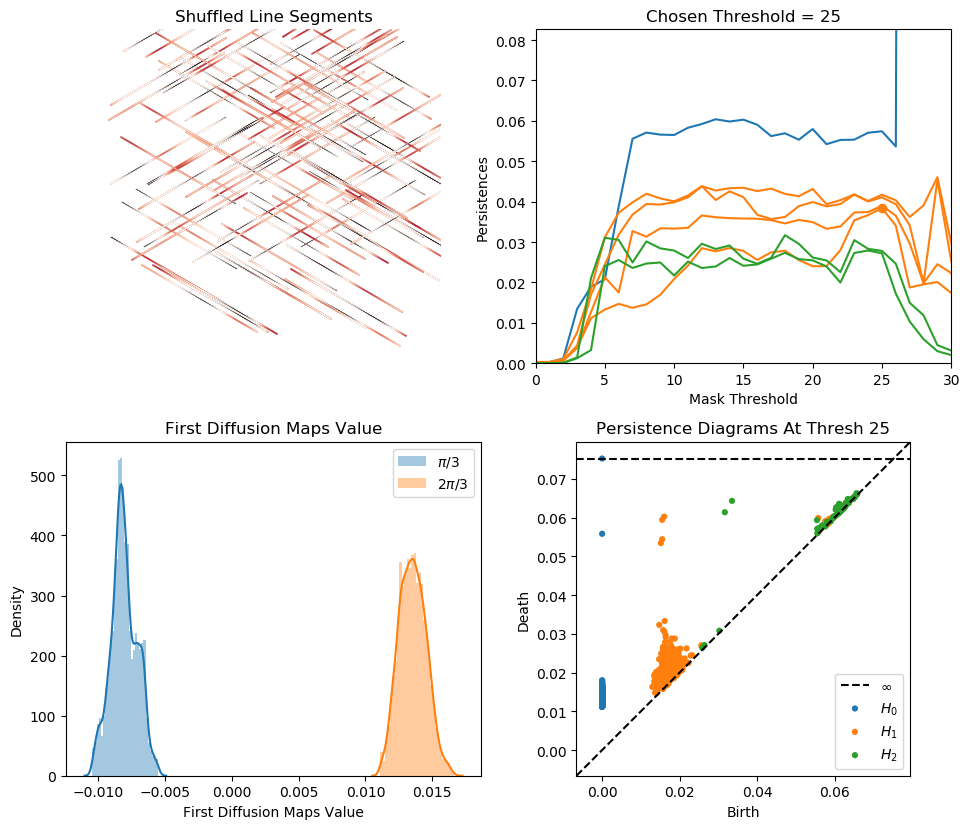

In [11]:
## Plot all results
import matplotlib.transforms as mtransforms
vmax = np.max(np.abs(ks.I))
vmin = -vmax
fac = 0.7
plt.figure(figsize=(fac*14, fac*12))
np.random.seed(0)
ax = plt.subplot(221)
NToPlot=100
locs = np.random.rand(NToPlot, 2)*150
for i in range(NToPlot):
    p = np.reshape(ks.patches[i, :], ks.pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    c = np.cos(ks.thetas[i])
    s = np.sin(ks.thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([0, 200])
plt.ylim([200, 0])
plt.axis('off')
plt.title("Shuffled Line Segments")

plt.subplot(222)
plt.plot(h0, c='C0')
plt.plot(h1s, c='C1')
plt.plot(h2s, c='C2')
plt.scatter([thresh], h1s[thresh, 3], c='C1')
plt.ylim([0, np.max(h1s)*1.4])
plt.xlim([0, 30])
plt.xlabel("Mask Threshold")
plt.ylabel("Persistences")
plt.title("Chosen Threshold = %i"%thresh)
plt.subplot(223)
pi_3 = Y[idxresort < nsamples, 0]
twopi_3 = Y[idxresort >= nsamples, 0]
sns.distplot(pi_3)
sns.distplot(twopi_3)
plt.legend(["$\\pi/3$", "$2\\pi/3$"])
plt.xlabel("First Diffusion Maps Value")
plt.ylabel("Density")
plt.title("First Diffusion Maps Value")
plt.tight_layout()
plt.subplot(224)
plot_dgms(dgms)
plt.title("Persistence Diagrams At Thresh %i"%thresh)
plt.tight_layout()
#plt.savefig("TwoTypes.png", bbox_inches='tight', dpi=400)
plt.savefig("TwoTypes.svg", bbox_inches='tight')